# Expression Evaluation (On-Disk, Comparison with Dask)

ironArray has transparent support for the evaluation of expressions whose operands are disk-based.  The main advantage of this is that you can perform operations with data that exceeds your available memory (even in compressed state).

On the other hand, disks are pretty much slower beasts than memory (although with the advent of SSDs, the gap is closing significantly during the last few years), so you should expect evaluation speeds going down significantly, but due to the on-the-fly compression, perhaps to as much as you can imagine.



In [1]:
%load_ext memprofiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iarray as ia
from ipython_memwatcher import MemWatcher

mw = MemWatcher()
mw.start_watching_memory()
meas = {}

In [1] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 157.039 MiB


Let's start providing some hints on what kind of speed you can expect from using ironArray with on-disk data.  So as to show this, we are going to use our original on-disk array and will create an on-disk outcome where we will put the result of our operations:

In [2]:
ia_precip = ia.open("precip-3m.iarr")
precip1 = ia_precip[0].copy()
precip2 = ia_precip[1].copy()
precip3 = ia_precip[2].copy()

In [2] used 870.289 MiB RAM in 32.589s, peaked 505.332 MiB above current, total RAM usage 1027.328 MiB


In this case, we are just getting views of the larger array that is on-disk.  Remember that views do not create new containers, so this is why the above operation is fast.  Now, let's build the expression for the mean values:

In [3]:
precip_mean = (precip1 + precip2 + precip3) / 3

In [3] used 4.262 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1031.590 MiB


and now let's evaluate and make sure that the result is created on-disk:

In [4]:
# with ia.config(storage=ia.Storage(urlpath="mean-3m.iarr")):
with ia.config(storage=None):
    precip_mean_disk = precip_mean.eval()
precip_mean

In [4] used 625.188 MiB RAM in 2.496s, peaked 0.000 MiB above current, total RAM usage 1656.777 MiB


In [5]:
meas["ia_mean_disk"] = mw.measurements

In [5] used -0.121 MiB RAM in 0.001s, peaked 0.121 MiB above current, total RAM usage 1656.656 MiB


We see that evaluation from disk takes quite more time than operating in memory, but this is kind of expected.  What we are more interested here is the amount of RAM needed to perform the evaluation has less than 100 MB (33 + 40 MB), whereas the output array is quite larger than this:

In [6]:
%ls -lh mean-3m.iarr

-rw-r--r--  1 aleix11alcacer  staff   388M Feb 26 08:59 mean-3m.iarr
In [6] used 1.168 MiB RAM in 0.173s, peaked 0.000 MiB above current, total RAM usage 1657.824 MiB


So, with a result size of more than 1 GB, it well above than the consumed memory.  This memory is probably being required by array temporaries (which Python takes some time to release back), so in the long run this figure should be considered more a temporary peak that will be eventually reclaimed by the interpreter for other uses.  But still, it is important to realize that such amount of memory is needed.

For the sake of comparison, let's see how similar array libraries perform at this.  Zarr is the most obvious container because it supports the same Blosc compressor, so this will allow for a apple to apple comparison.  Let's create a Zarr container out of our current one:

In [7]:
import zarr

shape = ia_precip.shape
dtype = np.float32
clevel = ia.Config().clevel
compressor = zarr.Blosc(clevel=clevel, cname="lz4")
# chunks = ia_precip.chunks
chunks = ia_precip.blocks


In [7] used 7.293 MiB RAM in 0.102s, peaked 0.000 MiB above current, total RAM usage 1665.117 MiB


Note that we are using the shape of the ironArray block as the shape of the chunk in Zarr.  This is because Dask (see later) uses chunks as the elementary units of parallelism, while ironArray uses blocks; so in order to compare apples with apples, this is the setup that makes sense. 

Now populate the Zarr array with the ironArray data:

In [8]:
zarr_precip1 = zarr.create(shape=shape[1:], chunks=chunks[1:], dtype=dtype, compressor=compressor)
zarr_precip2 = zarr.create(shape=shape[1:], chunks=chunks[1:], dtype=dtype, compressor=compressor)
zarr_precip3 = zarr.create(shape=shape[1:], chunks=chunks[1:], dtype=dtype, compressor=compressor)

precip1.copyto(zarr_precip1)
precip2.copyto(zarr_precip2)
precip3.copyto(zarr_precip3)

In [8] used 320.426 MiB RAM in 12.708s, peaked 233.191 MiB above current, total RAM usage 1985.543 MiB


and now compute the mean using Dask:

In [9]:
import dask
import dask.array as da

In [9] used 0.168 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 1985.711 MiB


In [10]:
with dask.config.set(scheduler="threads"):
    dask_precip1 = da.from_zarr(zarr_precip1)
    dask_precip2 = da.from_zarr(zarr_precip2)
    dask_precip3 = da.from_zarr(zarr_precip3)

    res = (dask_precip1 + dask_precip2 + dask_precip3) / 3
    zarr_precip_mean_disk = zarr.create(shape=shape[1:], chunks=chunks[1:], dtype=dtype, compressor=compressor)
    da.to_zarr(res, zarr_precip_mean_disk)

In [10] used 2234.375 MiB RAM in 15.500s, peaked 61.820 MiB above current, total RAM usage 4220.086 MiB


In [11]:
meas["dask_mean_disk"] = mw.measurements

In [11] used -0.219 MiB RAM in 0.001s, peaked 0.219 MiB above current, total RAM usage 4219.867 MiB


In this case we see that Dask+Zarr took about 3x more time than ironArray in performing the operations.  But perhaps more importantly, Dask+Zarr took a considerable about of peak RAM to complete the operation (more than 10 GB), which is much more than ironArray (around 100 MB).

Here it is a comparison of the times on a plot:

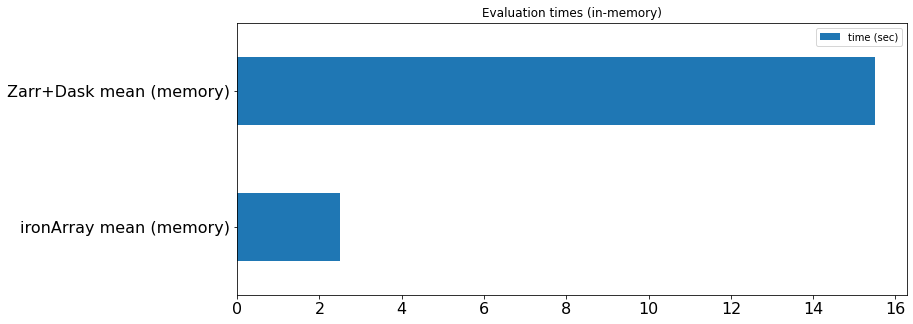

In [12] used 4.574 MiB RAM in 0.204s, peaked 0.250 MiB above current, total RAM usage 4224.441 MiB


In [12]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean (memory)", "Zarr+Dask mean (memory)"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean_disk"].time_delta, meas["dask_mean_disk"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (in-memory)")

And here the memory consumption for ironArray:

mprof.py: Sampling memory every 0.1s
running as a Python program...
In [13] used -2007.148 MiB RAM in 24.940s, peaked 2007.285 MiB above current, total RAM usage 2217.293 MiB


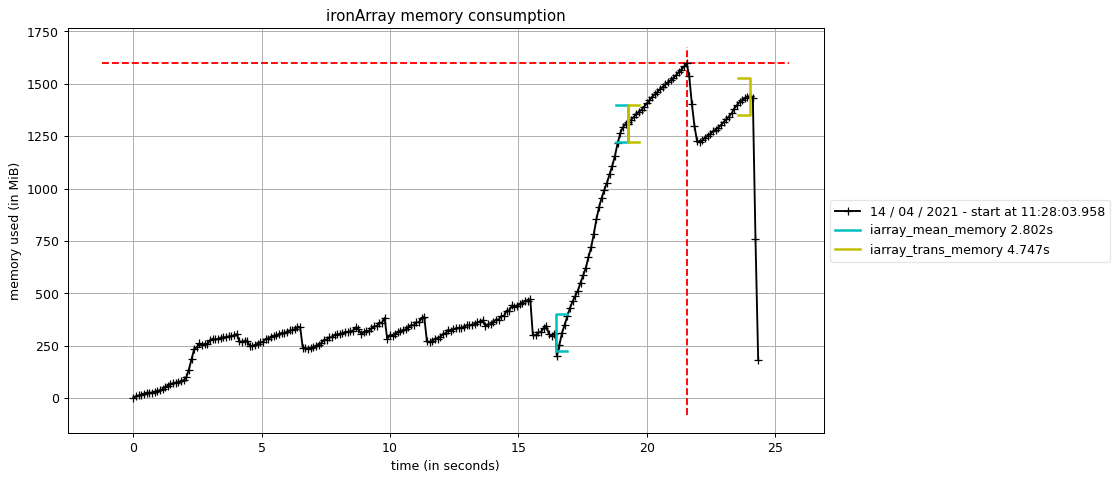

In [13]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

mprof.py: Sampling memory every 0.1s
running as a Python program...
In [14] used -633.734 MiB RAM in 23.773s, peaked 635.785 MiB above current, total RAM usage 1583.559 MiB


KeyboardInterrupt: 

/Users/aleix11alcacer/miniconda3/envs/iron-array/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2838: UserWarning: Unknown failure executing module: <mprof>
  warn('Unknown failure executing module: <%s>' % mod_name)


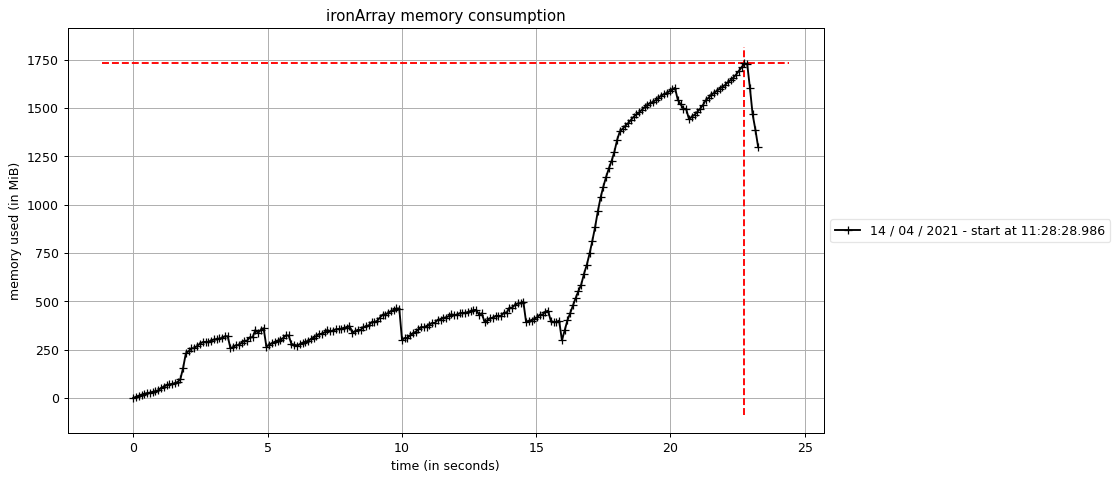

In [14]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

In this case we see that the first operation consumes a good amount of memory (~ 80 MB), while the second is much more contained (~ 50 MB).  This is possibly due to some warm-up effects during the first operation; after that, you should expect a rather contained memory usage with ironArray.  Indeed, using just 50 MB for performing operations that involve 3 input arrays of 3 GB and 1 output of 3 GB is a nice feature to have.

Let's do the same operations with dask:

mprof.py: Sampling memory every 0.1s
running as a Python program...
In [15] used 2.496 MiB RAM in 0.908s, peaked 0.000 MiB above current, total RAM usage 1586.055 MiB


KeyboardInterrupt: 

/Users/aleix11alcacer/miniconda3/envs/iron-array/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2838: UserWarning: Unknown failure executing module: <mprof>
  warn('Unknown failure executing module: <%s>' % mod_name)


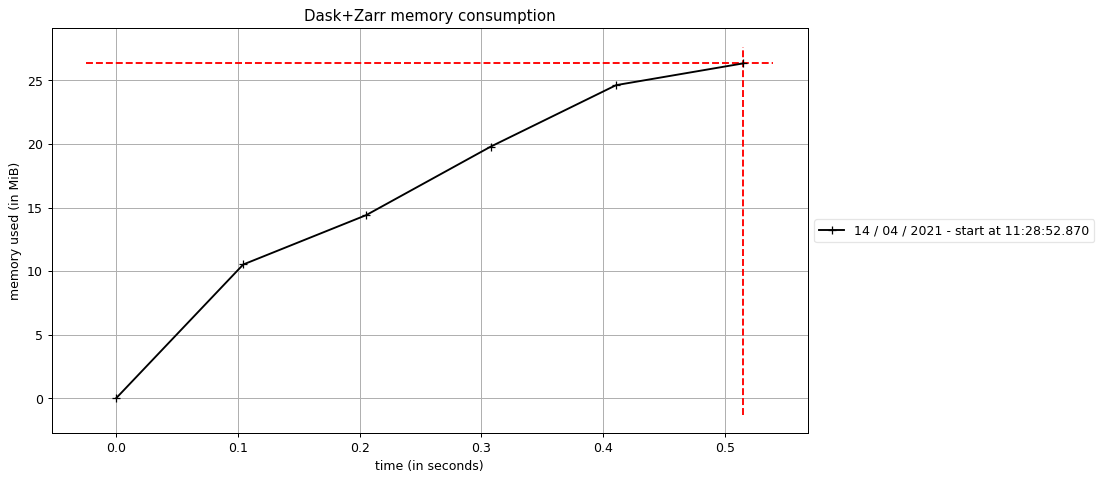

In [15]:
%rm dask_mean_memory.dat
%run -m mprof run -o dask_mean_memory.dat dask_mean_memory.py
%run -m mprof plot dask_mean_memory.dat -t "Dask+Zarr memory consumption"

mprof.py: Sampling memory every 0.1s
running as a Python program...
In [16] used 2.488 MiB RAM in 2.374s, peaked 0.000 MiB above current, total RAM usage 1588.543 MiB


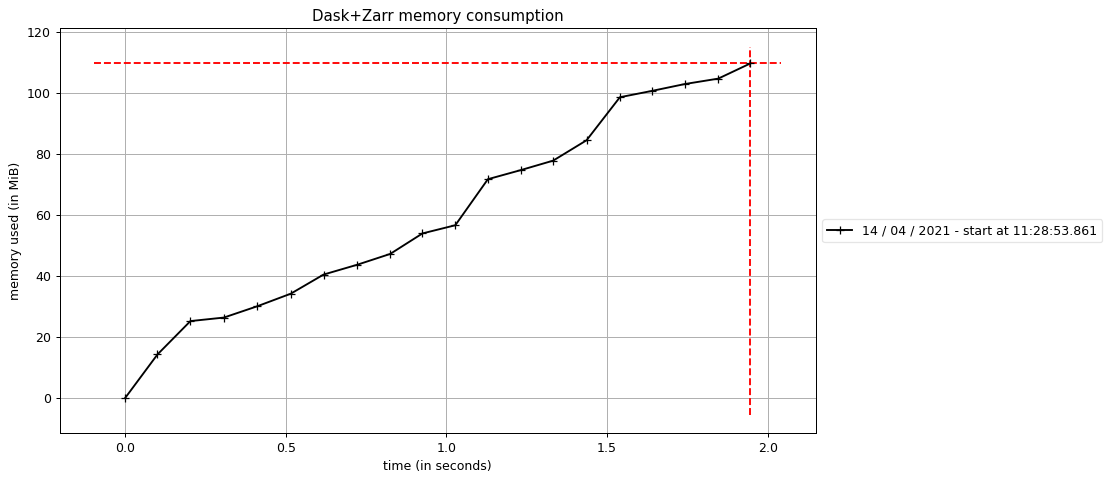

In [16]:
%rm dask_mean_memory.dat
%run -m mprof run -o dask_mean_memory.dat dask_mean_memory.py
%run -m mprof plot dask_mean_memory.dat -t "Dask+Zarr memory consumption"

Here we see that Dask + Zarr makes a more intensive use of the memory: 80 MB vs 300 GB that uses Dask for the first expression and 50 MB vs 200 MB for the second expression.  Also, Dask + Zarr is significantly slower when performing on-disk evaluations (~ 2x slower than ironArray in this case).

This is a general feature of ironArray: it performs evaluations fast while keeping memory usage low.  This allows to compute operations on arbitrarily large arrays (as long as disk storage allows) without worrying about RAM capacities.  Indeed speed is slower because disk I/O, but our prediction is that modern SSDs will be significantly closing the performance gap vs memory as times goes on.